In [124]:
# Import libraries
import os
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, PC, BicScore
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
# Load Data

GTD = pd.read_csv('C:/R Portfolio/Global_Terrorism_Prediction/globalterrorismdb_0522dist.csv', 
                     encoding = 'latin1',
                     low_memory = False)
GTD_1 = pd.read_csv('C:/R Portfolio/Global_Terrorism_Prediction/globalterrorismdb_2021Jan-June_1222dist.csv', 
                     encoding = 'latin1',
                     low_memory = False)
GTD_combined = pd.concat([GTD, GTD_1], ignore_index = True)
GTD_combined

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214661,202106300023,2021,6,30,NaN,0,NaN,4,Afghanistan,6,...,NaN,"""Gunmen blow up power pylon in Parwan,"" Afghan...","""Provinces hit by blackout after power pylon d...",NaN,START Primary Collection,-9,-9,0,-9,NaN
214662,202106300029,2021,6,30,06/30/2021,0,NaN,138,Myanmar,5,...,NaN,"""Spring Revolution Daily News for 16-30 June 2...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN
214663,202106300030,2021,6,30,NaN,1,08/07/2021,147,Nigeria,11,...,NaN,"""Boko Haram Releases Abducted Catholic Priest ...","""Kidnapped Maiduguri Catholic Priest regains f...","""ISWAP-Boko Haram Abduct Catholic Priest In Bo...",START Primary Collection,0,0,0,0,NaN
214664,202106300038,2021,6,30,NaN,0,NaN,45,Colombia,3,...,NaN,"""Two dead and one wounded after clashes betwee...",NaN,NaN,START Primary Collection,0,0,0,0,NaN


In [7]:
# Load Functions

execfile('C:/Python_Data_Sets/Functions 10_07_2023.py')

In [49]:
# Process Data

GTD_New = preprocess_data(GTD_combined)
GTD_New

,Year,Month,Day,Country,Region,Province,City,Longitude,Latitude,Attack,Target,Group,Weapon,Dead,Lethal
0,1970,7,2,Dominican Republic,Central America & Caribbean,National,Santo Domingo,-69.951164,18.456792,Assassination,Private,MANO-D,OtherWeapon,1.0,1
1,1970,0,0,Mexico,North America,Federal,Mexico city,-99.086624,19.371887,HostageKidnapAttack,GovtDip,23rd of September Communist League,OtherWeapon,0.0,0
2,1970,1,0,Philippines,Southeast Asia,Tarlac,Unknown,120.599741,15.478598,Assassination,JournalistsMedia,OtherGroup,OtherWeapon,1.0,1
3,1970,1,0,Greece,Western Europe,Attica,Athens,23.762728,37.997490,BombAttack,GovtDip,OtherGroup,Explosives,0.0,0
4,1970,1,0,Japan,East Asia,Fukouka,Fukouka,130.396361,33.580412,InfrastructureAttack,GovtDip,OtherGroup,Incendiary,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214661,2021,6,30,Afghanistan,South Asia,Parwan,Jangal Bagh,69.196838,35.054772,BombAttack,Utilities,OtherGroup,Explosives,0.0,0
214662,2021,6,30,Myanmar,Southeast Asia,Shan,Muse,97.897143,23.986739,HostageKidnapAttack,EduIns,OtherGroup,OtherWeapon,1.0,1
214663,2021,6,30,Nigeria,Sub-Saharan Africa,Borno,Unknown,13.014035,11.572869,HostageKidnapAttack,RelFigIns,Boko Haram,Firearms,0.0,0
214664,2021,6,30,Colombia,South America,Cauca,Unknown,-76.333069,3.104189,BombAttack,UnknownTarget,Revolutionary Armed Forces of Colombia (FARC) ...,Explosives,0.0,0


In [51]:
# Region Data

# EE Region Data
ME_data = GTD_New[GTD_New['Region'] == 'Middle East & North Africa']
ME_data

,Year,Month,Day,Country,Region,Province,City,Longitude,Latitude,Attack,Target,Group,Weapon,Dead,Lethal
95,1970,2,28,Jordan,Middle East & North Africa,Khalil,Hebron,35.094162,31.530243,ArmedAssaultAttack,Tourists,OtherGroup,Firearms,0.0,0
133,1970,3,14,Egypt,Middle East & North Africa,Alexandria,Alexandria,29.919167,31.198056,BombAttack,AirportsAircraft,OtherGroup,Explosives,0.0,0
158,1970,3,29,Lebanon,Middle East & North Africa,Beirut,Beirut,35.503513,33.888523,BombAttack,GovtDip,Popular Front for the Liberation of Palestine ...,Explosives,0.0,0
195,1970,4,15,Jordan,Middle East & North Africa,Amman,Amman,35.933331,31.950001,BombAttack,GovtDip,Popular Front for the Liberation of Palestine ...,Explosives,0.0,0
226,1970,4,25,Turkey,Middle East & North Africa,Istanbul,Istanbul,28.689863,41.106178,BombAttack,AirportsAircraft,Palestinians,Explosives,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214639,2021,6,29,Iraq,Middle East & North Africa,Diyala,Kifah,44.912047,34.003836,BombAttack,Utilities,OtherGroup,Explosives,1.0,1
214640,2021,6,29,Yemen,Middle East & North Africa,Al Hudaydah,Hays,43.478924,13.931337,ArmedAssaultAttack,Private,Houthi extremists (Ansar Allah),Explosives,0.0,0
214655,2021,6,30,Yemen,Middle East & North Africa,Marib,Sirwah district,45.011389,15.436667,BombAttack,UnknownTarget,Houthi extremists (Ansar Allah),Explosives,0.0,0
214658,2021,6,30,Saudi Arabia,Middle East & North Africa,OtherProvince,Unknown,NaN,NaN,BombAttack,Private,Houthi extremists (Ansar Allah),Explosives,0.0,0


In [52]:
# Group Infequent Categories
ME_data_1 = group_infrequent_categories(ME_data)
ME_data_1 

,Year,Month,Day,Country,Region,Province,City,Longitude,Latitude,Attack,Target,Group,Weapon,Dead,Lethal
95,1970,2,28,OtherCountry,Middle East & North Africa,OtherProvince,OtherCity,35.094162,31.530243,ArmedAssaultAttack,OtherTarget,OtherGroup,Firearms,0.0,0
133,1970,3,14,OtherCountry,Middle East & North Africa,OtherProvince,OtherCity,29.919167,31.198056,BombAttack,OtherTarget,OtherGroup,Explosives,0.0,0
158,1970,3,29,OtherCountry,Middle East & North Africa,OtherProvince,OtherCity,35.503513,33.888523,BombAttack,OtherTarget,OtherGroup,Explosives,0.0,0
195,1970,4,15,OtherCountry,Middle East & North Africa,OtherProvince,OtherCity,35.933331,31.950001,BombAttack,OtherTarget,OtherGroup,Explosives,0.0,0
226,1970,4,25,Turkey,Middle East & North Africa,OtherProvince,OtherCity,28.689863,41.106178,BombAttack,OtherTarget,OtherGroup,Explosives,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214639,2021,6,29,Iraq,Middle East & North Africa,Diyala,OtherCity,44.912047,34.003836,BombAttack,OtherTarget,OtherGroup,Explosives,1.0,1
214640,2021,6,29,Yemen,Middle East & North Africa,OtherProvince,OtherCity,43.478924,13.931337,ArmedAssaultAttack,Private,Houthi extremists (Ansar Allah),Explosives,0.0,0
214655,2021,6,30,Yemen,Middle East & North Africa,OtherProvince,OtherCity,45.011389,15.436667,BombAttack,OtherTarget,Houthi extremists (Ansar Allah),Explosives,0.0,0
214658,2021,6,30,OtherCountry,Middle East & North Africa,OtherProvince,Unknown,NaN,NaN,BombAttack,Private,Houthi extremists (Ansar Allah),Explosives,0.0,0


In [53]:
# Convert Data into Dummy format

ME_categorical_cols = ['Country', 'Province', 'City', 'Attack', 'Target', 'Group', 'Weapon']
ME_data_1 = pd.get_dummies(ME_data_1, columns = EE_categorical_cols)
# Remove unneeded columns
# Drop the specified columns
columns_to_drop = ['Month', 'Day', 'Dead', 'Region', 'Longitude', 'Latitude']
ME_data_1 = ME_data_1.drop(columns = columns_to_drop)
ME_data_1

,Year,Lethal,Country_Iraq,Country_OtherCountry,Country_Syria,Country_Turkey,Country_Yemen,Province_Al_Anbar,Province_Baghdad,Province_Diyala,...,Target_Military,Target_OtherTarget,Target_Police,Target_Private,Group_Houthi extremists (Ansar Allah),Group_Islamic State of Iraq and the Levant (ISIL),Group_OtherGroup,Weapon_Explosives,Weapon_Firearms,Weapon_OtherWeapon
95,1970,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
133,1970,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
158,1970,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
195,1970,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
226,1970,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214639,2021,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,1,0,0
214640,2021,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,1,0,0
214655,2021,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
214658,2021,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [54]:
# Apply statistical tests to data

ME_data_3 = ME_data_1
df = ME_data_3
target_column = 'Lethal'
ME_data_4 = preprocess_dataframe_three(df, target_column, correlation_threshold=0.7, variance_threshold=0.1)
# Remove "Attack_" and "Target_" from column names
ME_data_4.columns = ME_data_4.columns.str.replace('Attack_', '').str.replace('Target_', '').str.replace('Weapon_', '').str.replace('Country_', '').str.replace('Province_', '').str.replace('Group_', '')
ME_data_4

,Year,Lethal,OtherCountry,ArmedAssaultAttack,Military,OtherTarget,Police,Private,OtherWeapon
95,1970,0,1,1,0,1,0,0,0
133,1970,0,1,0,0,1,0,0,0
158,1970,0,1,0,0,1,0,0,0
195,1970,0,1,0,0,1,0,0,0
226,1970,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
214639,2021,1,0,0,0,1,0,0,0
214640,2021,0,0,1,0,0,0,1,0
214655,2021,0,0,0,0,1,0,0,0
214658,2021,0,1,0,0,0,0,1,0


In [55]:
# Split data for proportion and year
# Select the first 75% of rows
total_rows = len(ME_data_4)
rows_to_select = round(total_rows * 0.75)
ME_data_4_Prop = ME_data_4[:rows_to_select]
ME_Proportion_Data = ME_data_4_Prop.drop('Year', axis = 1)
ME_Year_Data = ME_data_4[ME_data_4["Year"] == 2019]
ME_Year_Data = ME_data_4.drop('Year', axis = 1)
ME_Year_Data

,Lethal,OtherCountry,ArmedAssaultAttack,Military,OtherTarget,Police,Private,OtherWeapon
95,0,1,1,0,1,0,0,0
133,0,1,0,0,1,0,0,0
158,0,1,0,0,1,0,0,0
195,0,1,0,0,1,0,0,0
226,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
214639,1,0,0,0,1,0,0,0
214640,0,0,1,0,0,0,1,0
214655,0,0,0,0,1,0,0,0
214658,0,1,0,0,0,0,1,0


In [56]:
ME_Proportion_Data

,Lethal,OtherCountry,ArmedAssaultAttack,Military,OtherTarget,Police,Private,OtherWeapon
95,0,1,1,0,1,0,0,0
133,0,1,0,0,1,0,0,0
158,0,1,0,0,1,0,0,0
195,0,1,0,0,1,0,0,0
226,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
165570,0,1,0,0,0,0,1,0
165571,0,1,0,0,0,0,1,0
165574,1,0,0,0,0,0,0,0
165575,1,0,0,0,0,0,0,0


# Construct Bayesian Network

This section presents the code required to build and visualise the Bayesian Network constructed using the hill climbing algorithym. The HillClimbSearch algorithm is a heuristic search algorithm used for learning the structure of a Bayesian network from data. It aims to find the most likely structure of the network that best fits the data provided.

Here's a high-level description of how the HillClimbSearch algorithm works:

Initialize the Network: The algorithm starts with an empty Bayesian network and an empty set of edges.

Evaluate Model Score: It computes a score for the current model using a scoring metric such as the Bayesian Information Criterion (BIC), Akaike Information Criterion (AIC), or the Maximum Likelihood Estimate (MLE) score. The scoring metric helps evaluate how well the model fits the data while penalizing complex models to avoid overfitting.

Generate Candidates: The algorithm generates all possible single-edge additions and single-edge deletions to the current model. It considers each candidate structure that could be obtained by adding or removing a single edge.

Evaluate Candidates: For each candidate model generated in the previous step, it computes the score using the same scoring metric as in step 2.

Select Best Candidate: The algorithm selects the candidate structure that results in the highest score among all the generated candidates. If the best score is higher than the current model's score, the current model is updated with the best candidate structure (either adding or removing a single edge). If the best score is not an improvement over the current model's score, the algorithm terminates as it has found a local optimum.

Repeat: Steps 2 to 5 are repeated iteratively until no further improvement can be made in the model score. This is a local search process, and the algorithm aims to find the best structure within a local neighborhood.

Output: The final output is the Bayesian network structure with the highest score, representing the best-fit model for the given data.

It's important to note that the HillClimbSearch algorithm is a greedy search algorithm, and its final output depends on the initial structure and the scoring metric used. It may not guarantee the globally optimal Bayesian network structure, as it could get stuck in a local optimum. Therefore, it is often recommended to perform multiple runs with different initial structures and scoring metrics to obtain a more robust Bayesian network model. Additionally, the HillClimbSearch algorithm can be computationally expensive for large datasets or complex models.

In [67]:
# Initialize a HillClimbSearch object and perform the structure learning
hc = HillClimbSearch(ME_Proportion_Data)

# Define the edges you want to avoid (edges you don't want in the network)
no_edges_list = [
    ('Military', 'OtherTarget'),
    ('Military', 'Police'),
    ('Military', 'Private'),
    ('OtherTarget', 'Military'),
    ('Police', 'Military'),
    ('Private', 'Military'),
    ('OtherTarget', 'Police'),
    ('OtherTarget', 'Private'),
    ('Police', 'OtherTarget'),
    ('Private', 'OtherTarget'),
    ('Police', 'Private'),
    ('Private', 'Police'),
    # Add more tuples to avoid other connections as needed
]

# Perform the structure learning while avoiding the specified edges
best_model = hc.estimate(black_list=no_edges_list)

# Manually compute the CPDs for each variable
cpds = {}
for node in best_model.nodes():
    # Get the parents of the current node
    parents = best_model.get_parents(node)
    print(f"Parents of {node}: {parents}")  # Debug statement to check parents
    if not parents:
        # Handle root nodes directly
        cpd = ME_Proportion_Data[node].value_counts(normalize=True).sort_index().values
        cpd = cpd.reshape(-1, 1)  # Convert to 2D array
    else:
        # Count unique values for each parent node combination
        parent_combinations = ME_Proportion_Data.groupby(parents)[node].value_counts().unstack().fillna(0)
        # Convert counts to probabilities by normalizing
        cpd = parent_combinations.div(parent_combinations.sum(axis=1), axis=0)
    # Create a TabularCPD with the computed probabilities
    cpds[node] = cpd

# Print the CPDs for each variable
for node, cpd in cpds.items():
    print(f"CPD for node {node}:")
    print(cpd)

  0%|          | 0/1000000 [00:00<?, ?it/s]

Parents of Lethal: ['OtherCountry', 'ArmedAssaultAttack', 'OtherWeapon', 'Private', 'Military', 'Police']
Parents of OtherCountry: ['OtherWeapon', 'Military']
Parents of ArmedAssaultAttack: ['Police', 'Military', 'OtherWeapon', 'OtherCountry']
Parents of Military: ['OtherWeapon']
Parents of OtherTarget: ['Lethal', 'ArmedAssaultAttack', 'OtherCountry', 'OtherWeapon']
Parents of Police: ['OtherWeapon', 'OtherCountry']
Parents of Private: ['ArmedAssaultAttack', 'OtherWeapon', 'OtherCountry']
Parents of OtherWeapon: []
CPD for node Lethal:
Lethal                                                                      0  \
OtherCountry ArmedAssaultAttack OtherWeapon Private Military Police             
0            0                  0           0       0        0       0.494767   
                                                             1       0.397238   
                                                    1        0       0.299352   
                                            1       0

The above output represents the Conditional Probability Distributions (CPDs) for each variable in the Bayesian network. Each CPD is a table that shows the conditional probabilities of a node's values given the values of its parent nodes. Each row in the CPD tables represents a specific combination of parent node values, and the values in the table represent the probabilities of the corresponding node being 0 or 1.The CPDs are essential for calculating the likelihood of different states of nodes in the Bayesian network based on the observed data. They capture the underlying probabilistic relationships between the nodes in the network.

CPD for node Lethal: This table shows the probabilities of the "Lethal" node being 0 or 1 given different combinations of its parent nodes' values. For example, when all parent nodes are 0 (OtherCountry, ArmedAssaultAttack, OtherTarget, OtherWeapon, Military, Private, and Police), the probability of "Lethal" being 0 is approximately 0.439882, and the probability of it being 1 is approximately 0.560118.

CPD for node OtherCountry: This table shows the probabilities of the "OtherCountry" node being 0 or 1 given different combinations of its parent nodes' values (OtherWeapon, OtherTarget, Military, Private, and Police).

CPD for node ArmedAssaultAttack: This table shows the probabilities of the "ArmedAssaultAttack" node being 0 or 1 given different combinations of its parent nodes' values (Police, Military, OtherWeapon, Private, and OtherCountry).

CPD for node Military: This table shows the probabilities of the "Military" node being 0 or 1 given different combinations of its parent nodes' values (Private and OtherTarget).

CPD for node OtherTarget: This table shows the probabilities of the "OtherTarget" node being 0 or 1 given different combinations of its parent nodes' values (Private and Police).

CPD for node Police: This table shows the probabilities of the "Police" node being 0 or 1 given the value of its parent node (Private).

CPD for node Private: This table represents the conditional probability distribution of the "Private" node. Since it has no parent nodes, the CPD shows the unconditional probabilities of "Private" being 0 or 1, which are approximately 0.7026 and 0.2974, respectively.

CPD for node OtherWeapon: This table shows the probabilities of the "OtherWeapon" node being 0 or 1 given the value of its parent node (Police).

In [68]:
# Display the edges of the learned Bayesian Network
print("Edges of the Bayesian Network:")
print(best_model.edges())
# Each pair of edges within each bracket indicates which variables connect together in the network

Edges of the Bayesian Network:
[('Lethal', 'OtherTarget'), ('OtherCountry', 'Lethal'), ('OtherCountry', 'Private'), ('OtherCountry', 'OtherTarget'), ('OtherCountry', 'ArmedAssaultAttack'), ('OtherCountry', 'Police'), ('ArmedAssaultAttack', 'Lethal'), ('ArmedAssaultAttack', 'Private'), ('ArmedAssaultAttack', 'OtherTarget'), ('Military', 'ArmedAssaultAttack'), ('Military', 'Lethal'), ('Military', 'OtherCountry'), ('Police', 'ArmedAssaultAttack'), ('Police', 'Lethal'), ('Private', 'Lethal'), ('OtherWeapon', 'OtherCountry'), ('OtherWeapon', 'Lethal'), ('OtherWeapon', 'Private'), ('OtherWeapon', 'Police'), ('OtherWeapon', 'ArmedAssaultAttack'), ('OtherWeapon', 'OtherTarget'), ('OtherWeapon', 'Military')]


# Visualise the Hill Climb Network

This section presents the code required to visualise the above network

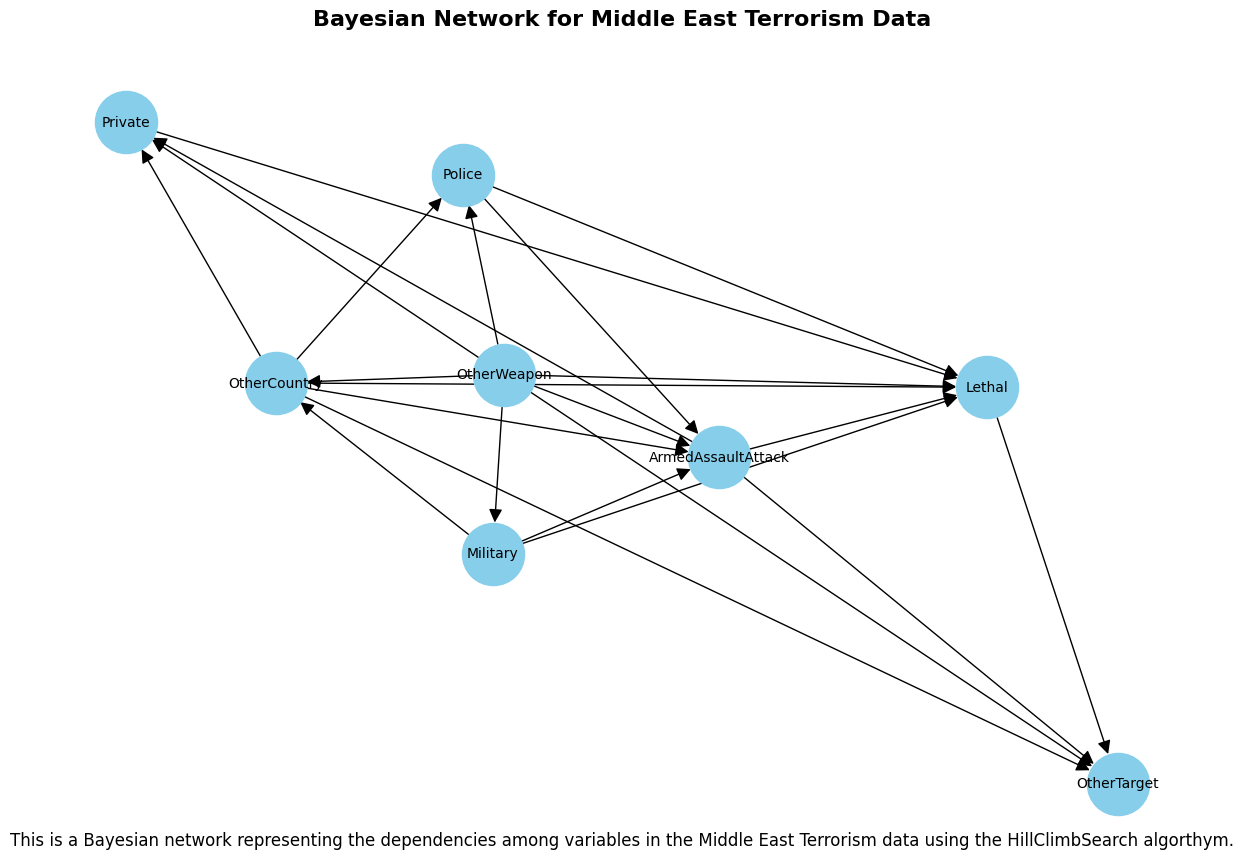

In [84]:
# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph based on the learned Bayesian Network
edges = [
    ('Lethal', 'OtherTarget'),
    ('OtherCountry', 'Lethal'),
    ('OtherCountry', 'Private'),
    ('OtherCountry', 'OtherTarget'),
    ('OtherCountry', 'ArmedAssaultAttack'),
    ('OtherCountry', 'Police'),
    ('ArmedAssaultAttack', 'Lethal'),
    ('ArmedAssaultAttack', 'Private'),
    ('ArmedAssaultAttack', 'OtherTarget'),
    ('Military', 'ArmedAssaultAttack'),
    ('Military', 'Lethal'),
    ('Military', 'OtherCountry'),
    ('Police', 'ArmedAssaultAttack'),
    ('Police', 'Lethal'),
    ('Private', 'Lethal'),
    ('OtherWeapon', 'OtherCountry'),
    ('OtherWeapon', 'Lethal'),
    ('OtherWeapon', 'Private'),
    ('OtherWeapon', 'Police'),
    ('OtherWeapon', 'ArmedAssaultAttack'),
    ('OtherWeapon', 'OtherTarget'),
    ('OtherWeapon', 'Military')
]

G.add_edges_from(edges)

# Plot the graph
plt.figure(figsize = (12, 8))
pos = nx.spring_layout(G, seed = 42)  # Position nodes using spring layout algorithm
nx.draw(G, pos, with_labels = True, node_size = 2000, font_size = 10, node_color = 'skyblue', arrowsize = 20)
plt.title("Bayesian Network for Middle East Terrorism Data", fontsize = 16, fontweight = "bold", pad = 20)

# Add the caption (centered)
caption = "This is a Bayesian network representing the dependencies among variables in the Middle East Terrorism data using the HillClimbSearch algorthym."
plt.figtext(0.5, 0.01, caption, wrap = True, horizontalalignment = 'center', fontsize = 12)

# Save the image as a PNG file
plt.savefig("HC_ME_bayesian_network.png", format = "png")

plt.show()

# Peter Clark Constraint-based algorithm Network

This section constructs a network using the peter clark constraint based network approach. The PC algorithm uses conditional independence tests (such as the chi-square test) to determine the absence of edges between pairs of variables. It starts by building a complete undirected graph and then progressively removes edges based on conditional independence tests.

The general steps of the PC algorithm are as follows:

Build a complete undirected graph with all variables as nodes. For each pair of nodes, perform conditional independence tests to identify independent nodes (i.e., nodes that have no direct edge between them).

Remove edges based on the results of conditional independence tests.

Perform a graph search to orient the edges and create the directed acyclic graph (DAG) structure.

The PC algorithm relies on statistical independence tests, and the choice of the test can affect the algorithm's accuracy and performance. The algorithm may also require some additional post-processing, such as dealing with latent variables or handling multiple testing corrections.

In [97]:
# Initialize the PC algorithm and perform structure learning
pc = PC(ME_Proportion_Data)
pc_best_edges = pc.estimate()

# Create a BayesianModel based on the learned edges
pc_model = BayesianModel(pc_best_edges)

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Nicholas\anaconda3\lib\site-packages\pgmpy\estimators\CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
C:\Users\Nicholas\anaconda3\lib\site-packages\pgmpy\estimators\CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
C:\Users\Nicholas\anaconda3\lib\site-packages\pgmpy\estimators\CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.grou

In [96]:
# Define the edges you want to avoid (edges you don't want in the network)
no_edges_list = [
    ('Military', 'OtherTarget'),
    ('Military', 'Police'),
    ('Military', 'Private'),
    ('OtherTarget', 'Military'),
    ('Police', 'Military'),
    ('Private', 'Military'),
    ('OtherTarget', 'Police'),
    ('OtherTarget', 'Private'),
    ('Police', 'OtherTarget'),
    ('Private', 'OtherTarget'),
    ('Police', 'Private'),
    ('Private', 'Police'),
    # Add more tuples to avoid other connections as needed
]

# Initialize the PC algorithm
pc = PC(ME_Proportion_Data)

# Perform the structure learning while avoiding the specified edges
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    best_model = pc.estimate(black_list=no_edges_list)

# Manually compute the CPDs for each variable
cpds = {}
for node in best_model.nodes():
    # Get the parents of the current node
    parents = best_model.get_parents(node)
    print(f"Parents of {node}: {parents}")  # Debug statement to check parents
    if not parents:
        # Handle root nodes directly
        cpd = ME_Proportion_Data[node].value_counts(normalize=True).sort_index().values
        cpd = cpd.reshape(-1, 1)  # Convert to 2D array
    else:
        # Count unique values for each parent node combination
        parent_combinations = ME_Proportion_Data.groupby(parents)[node].value_counts().unstack().fillna(0)
        # Convert counts to probabilities by normalizing
        cpd = parent_combinations.div(parent_combinations.sum(axis=1), axis=0)
    # Create a TabularCPD with the computed probabilities
    cpds[node] = cpd

# Print the CPDs for each variable
for node, cpd in cpds.items():
    print(f"CPD for node {node}:")
    print(cpd)

  0%|          | 0/5 [00:00<?, ?it/s]

Parents of Private: ['Police']
Parents of OtherTarget: ['Private', 'Police']
Parents of Military: ['Police', 'Private', 'OtherTarget']
Parents of ArmedAssaultAttack: ['Military', 'Police', 'OtherWeapon']
Parents of Police: []
Parents of Lethal: ['OtherTarget', 'ArmedAssaultAttack']
Parents of OtherCountry: ['Lethal', 'Military']
Parents of OtherWeapon: ['Police']
CPD for node Private:
Private         0         1
Police                     
0        0.653151  0.346849
1        1.000000  0.000000
CPD for node OtherTarget:
OtherTarget          0       1
Private Police                
0       0       0.6228  0.3772
        1       1.0000  0.0000
1       0       1.0000  0.0000
CPD for node Military:
Military                           0         1
Police Private OtherTarget                    
0      0       0            0.498137  0.501863
               1            1.000000  0.000000
       1       0            1.000000  0.000000
1      0       0            1.000000  0.000000
CPD for node A

C:\Users\Nicholas\anaconda3\lib\site-packages\pgmpy\base\DAG.py:1196: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  warn(


The provided output represents the Conditional Probability Distributions (CPDs) of the Bayesian network learned using the Peter Clark constraint-based algorithm. Each CPD shows the conditional probabilities of a variable given its parents in the Bayesian network. Let's interpret each CPD:

CPD for node Private:

Given that Police is 0, the probability of Private being 0 is approximately 0.653, and the probability of Private being 1 is approximately 0.347.
Given that Police is 1, the probability of Private being 0 is 1.0, and the probability of Private being 1 is 0.0.
CPD for node OtherTarget:

Given that Private and Police are 0, the probability of OtherTarget being 0 is approximately 0.623, and the probability of OtherTarget being 1 is approximately 0.377.
Given that Private is 1 and Police is 0, the probability of OtherTarget being 0 is 1.0, and the probability of OtherTarget being 1 is 0.0.
Given that Private is 0 and Police is 1, the probability of OtherTarget being 0 is 1.0, and the probability of OtherTarget being 1 is 0.0.
CPD for node Military:

Given that Police and Private are 0, and OtherTarget is 0, the probability of Military being 0 is approximately 0.498, and the probability of Military being 1 is approximately 0.502.
Given that Police is 1, Private is 0, and OtherTarget is 0, the probability of Military being 0 is 1.0, and the probability of Military being 1 is 0.0.
Given that Police is 0, Private is 1, and OtherTarget is 0, the probability of Military being 0 is 1.0, and the probability of Military being 1 is 0.0.
Given that Police is 0, Private is 0, and OtherTarget is 1, the probability of Military being 0 is 1.0, and the probability of Military being 1 is 0.0.
CPD for node ArmedAssaultAttack:

Given that Military, Police, and OtherWeapon are 0, the probability of ArmedAssaultAttack being 0 is approximately 0.865, and the probability of ArmedAssaultAttack being 1 is approximately 0.135.
Given that Military, Police, and OtherWeapon are 1, the probability of ArmedAssaultAttack being 0 is approximately 0.854, and the probability of ArmedAssaultAttack being 1 is approximately 0.147.
Given that Military is 0, Police is 1, and OtherWeapon is 0, the probability of ArmedAssaultAttack being 0 is approximately 0.675, and the probability of ArmedAssaultAttack being 1 is approximately 0.325.
Given that Military is 0, Police is 1, and OtherWeapon is 1, the probability of ArmedAssaultAttack being 0 is approximately 0.761, and the probability of ArmedAssaultAttack being 1 is approximately 0.239.
Given that Military is 1, Police is 0, and OtherWeapon is 0, the probability of ArmedAssaultAttack being 0 is approximately 0.679, and the probability of ArmedAssaultAttack being 1 is approximately 0.321.
Given that Military is 1, Police is 0, and OtherWeapon is 1, the probability of ArmedAssaultAttack being 0 is approximately 0.830, and the probability of ArmedAssaultAttack being 1 is approximately 0.170.
CPD for node Police:

The probability of Police being 0 is approximately 0.858, and the probability of Police being 1 is approximately 0.142.
CPD for node Lethal:

Given that OtherTarget and ArmedAssaultAttack are 0, the probability of Lethal being 0 is approximately 0.443, and the probability of Lethal being 1 is approximately 0.557.
Given that OtherTarget is 0 and ArmedAssaultAttack is 1, the probability of Lethal being 0 is approximately 0.287, and the probability of Lethal being 1 is approximately 0.713.
Given that OtherTarget is 1 and ArmedAssaultAttack is 0, the probability of Lethal being 0 is approximately 0.622, and the probability of Lethal being 1 is approximately 0.378.
Given that OtherTarget and ArmedAssaultAttack are 1, the probability of Lethal being 0 is approximately 0.354, and the probability of Lethal being 1 is approximately 0.646.
CPD for node OtherCountry:

Given that Lethal and Military are 0, the probability of OtherCountry being 0 is approximately 0.595, and the probability of OtherCountry being 1 is approximately 0.405.
Given that Lethal is 0 and Military is 1, the probability of OtherCountry being 0 is approximately 0.458, and the probability of OtherCountry being 1 is approximately 0.542.
Given that Lethal is 1 and Military is 0, the probability of OtherCountry being 0 is approximately 0.750, and the probability of OtherCountry being 1 is approximately 0.250.
Given that Lethal and Military are 1, the probability of OtherCountry being 0 is approximately 0.709, and the probability of OtherCountry being 1 is approximately 0.291.
CPD for node OtherWeapon:

The probability of OtherWeapon being 0 is approximately 0.868, and the probability of OtherWeapon being 1 is approximately 0.132.
Given that Police is 1, the probability of OtherWeapon being 0 is approximately 0.928, and the probability of OtherWeapon being 1 is approximately 0.072.
Each CPD provides a conditional probability distribution for the corresponding node in the Bayesian network. The probabilities are computed based on the data and the relationships between nodes in the network.

In [89]:
# List the edges
print("Edges of the Bayesian Network:")
print(pc_model.edges())

Edges of the Bayesian Network:
[('Private', 'OtherTarget'), ('Private', 'Military'), ('OtherTarget', 'Lethal'), ('OtherTarget', 'Military'), ('Military', 'ArmedAssaultAttack'), ('Military', 'OtherCountry'), ('ArmedAssaultAttack', 'Lethal'), ('Police', 'Military'), ('Police', 'ArmedAssaultAttack'), ('Police', 'OtherWeapon'), ('Police', 'OtherTarget'), ('Police', 'Private'), ('Lethal', 'OtherCountry'), ('OtherWeapon', 'ArmedAssaultAttack')]


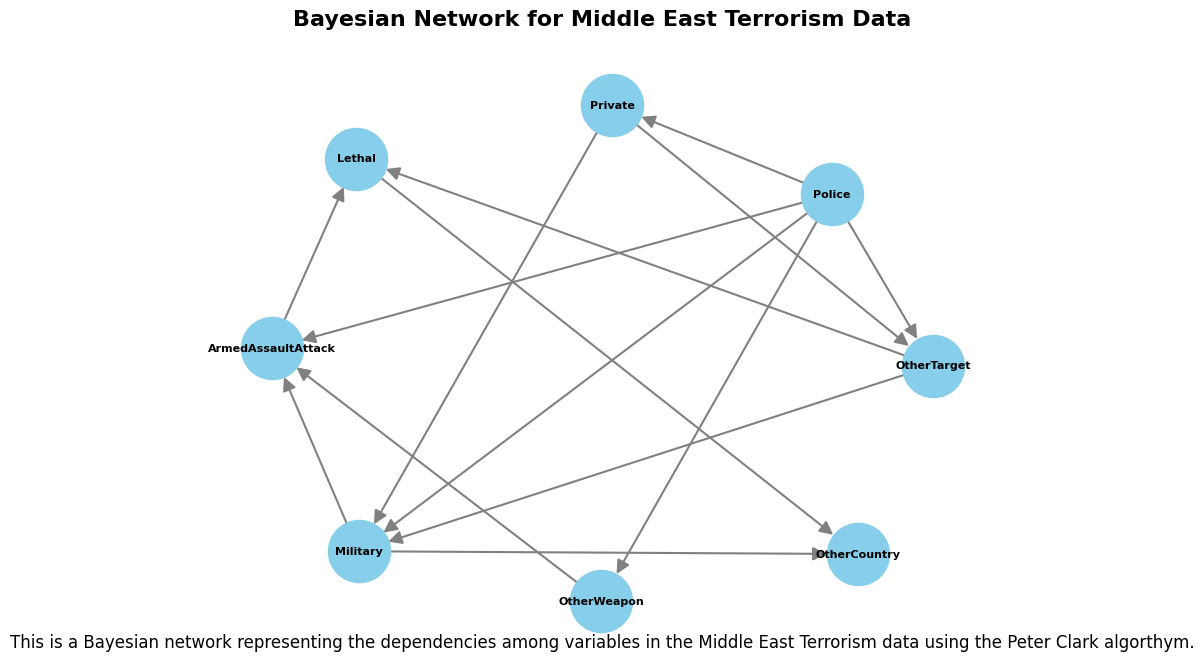

In [87]:
# Visualize the network
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(pc_model, seed=42)
nx.draw(pc_model, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=8, font_weight='bold', arrowsize=20, edge_color='gray', width=1.5)
plt.title("Bayesian Network for Middle East Terrorism Data", fontsize = 16, fontweight = "bold", pad = 20)

# Add the caption (centered)
caption = "This is a Bayesian network representing the dependencies among variables in the Middle East Terrorism data using the Peter Clark algorthym."
plt.figtext(0.5, 0.01, caption, wrap = True, horizontalalignment = 'center', fontsize = 12)

# Save the image as a PNG file
plt.savefig("PC_ME_bayesian_network.png", format = "png")

plt.show()

In [128]:
# Initialize the BicScore to perform scoring
bic = BicScore(ME_Proportion_Data)

# Perform the structure learning using the HillClimbSearch algorithm
hc = HillClimbSearch(ME_Proportion_Data)

# Estimate the best model using BicScore as the scoring method
best_model = hc.estimate(scoring_method=bic)

# Create a BayesianModel based on the learned edges
model = BayesianModel(best_model.edges())

# Create an instance of the MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, ME_Proportion_Data)

# Estimate the CPDs for the best_model using MaximumLikelihoodEstimator
model.fit(ME_Proportion_Data, estimator=MaximumLikelihoodEstimator)

# Print the CPDs for each variable
cpds = {}
for node in model.nodes():
    cpds[node] = mle.estimate_cpd(node)

    print(f"CPD for node {node}:")
    print(cpds[node])
    print()

  0%|          | 0/1000000 [00:00<?, ?it/s]

CPD for node Lethal:
+-----------+----------+
| Lethal(0) | 0.447934 |
+-----------+----------+
| Lethal(1) | 0.552066 |
+-----------+----------+

CPD for node OtherCountry:
+-----------------+---------------------+---------------------+
| Lethal          | Lethal(0)           | Lethal(1)           |
+-----------------+---------------------+---------------------+
| OtherCountry(0) | 0.575072521756527   | 0.7421069718367016  |
+-----------------+---------------------+---------------------+
| OtherCountry(1) | 0.42492747824347304 | 0.25789302816329845 |
+-----------------+---------------------+---------------------+

CPD for node ArmedAssaultAttack:
+-----------------------+---------------------+---------------------+---------------------+---------------------+
| Lethal                | Lethal(0)           | Lethal(0)           | Lethal(1)           | Lethal(1)           |
+-----------------------+---------------------+---------------------+---------------------+---------------------+
| 

C:\Users\Nicholas\anaconda3\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


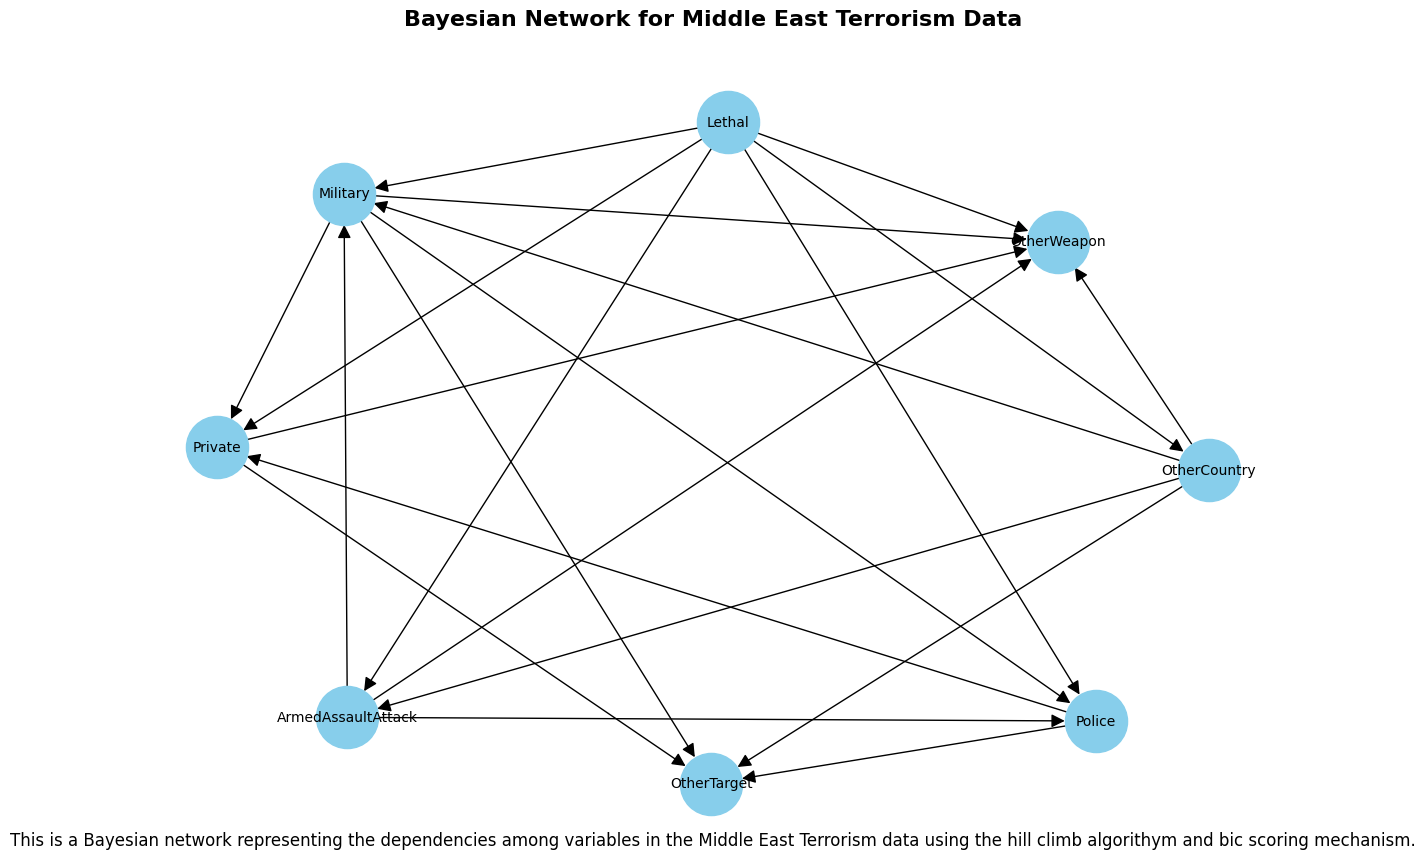

In [131]:
# Plot the graph
plt.figure(figsize = (12, 8))
pos = nx.spring_layout(model, seed = 42)  # Position nodes using spring layout algorithm
nx.draw(model, pos, with_labels = True, node_size = 2000, font_size = 10, node_color = 'skyblue', arrowsize = 20)
plt.title("Bayesian Network for Middle East Terrorism Data", fontsize = 16, fontweight = "bold", pad = 20)

# Add the caption (centered)
caption = "This is a Bayesian network representing the dependencies among variables in the Middle East Terrorism data using the hill climb algorithym and bic scoring mechanism."
plt.figtext(0.5, 0.01, caption, wrap = True, horizontalalignment = 'center', fontsize = 12)

plt.show()